In [61]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

from pypfopt.efficient_frontier import EfficientFrontier
from sklearn.preprocessing import TargetEncoder
from tslearn.clustering import TimeSeriesKMeans

from pypfopt import risk_models, expected_returns, plotting
from scipy.stats import f_oneway as anova, kruskal

In [62]:
df = pd.read_parquet("data/full.parquet")

df

State    0         1         2         3         4  \
Ticker Date                                                            
A      2013-07-08    CA  1.0  1.005410  1.021416  1.030658  1.031335   
       2013-07-15    CA  1.0  0.995663  0.989156  0.995446  1.001952   
       2013-07-22    CA  1.0  0.992949  0.999145  0.997009  0.974359   
       2013-07-29    CA  1.0  0.989193  0.986546  1.015439  1.022938   
       2013-08-05    CA  1.0  1.003047  1.007401  0.998041  1.006095   
...                 ...  ...       ...       ...       ...       ...   
ZYXI   2023-04-24    CO  1.0  0.976231  0.947368  0.956706  0.971138   
       2023-05-01    CO  1.0  1.075712  1.091454  0.702399  0.702399   
       2023-05-08    CO  1.0  1.010471  1.006283  1.019895  0.997906   
       2023-05-15    CO  1.0  0.985432  1.001041  0.996878  1.002081   
       2023-06-05    CO  1.0  0.986037  0.973147  0.953813  0.940924   

                          5         6         7         8         9  
Ticker Date                                                          
A      2013-07-08  1.039450  1.034941  1.028179  1.034716  1.041479  
       2013-07-15  1.014964  1.007807  1.014097  1.011928  0.988939  
       2013-07-22  0.968803  0.958333  0.955769  0.983761  0.991026  
       2013-07-29  1.013233  1.016321  1.020732  1.011248  1.019409  
       2013-08-05  1.011101  1.021332  1.012408  1.022203  1.018502  
...                     ...       ...       ...       ...       ...  
ZYXI   2023-04-24  1.132428  1.218166  1.235993  0.795416  0.795416  
       2023-05-01  0.715892  0.723388  0.720390  0.730135  0.714393  
       2023-05-08  1.006283  0.991623  1.007330  1.003141  1.008377  
       2023-05-15  1.015609  1.006244  0.993757  0.976067  0.978148  
       2023-06-05  0.922664  0.925886  1.020408  1.017186  1.034372  

[1416389 rows x 11 columns]

In [63]:
start = pd.to_datetime("2015-01-01")
end = pd.to_datetime("2020-12-31")

df = df.loc[(df.index.get_level_values("Date") >= start) & (df.index.get_level_values("Date") <= end)]

In [64]:
abbrevs = [
    "WA", "OR", "CA", "NV", "HI", "AK", "ID", "MT", "WY", "UT", "CO", # West
    "AZ", "NM", "TX", "OK", # Southwest
    "ND", "SD", "NE", "KS", "MN", "IA", "MO", "WI", "IL", "MI", "IN", "OH", # Midwest
    "AR", "LA", "MS", "AL", "TN", "KY", "WV", "VA", "NC", "SC", "GA", "FL", # Southeast
    "PA", "NY", "VT", "NH", "ME", "MA", "RI", "CT", "NJ", "DE", "MD" # Northeast
]

df = df[df["State"].isin(abbrevs)]

In [65]:
df.loc[df["State"].isin(abbrevs[0:11]), "Region"] = "W"
df.loc[df["State"].isin(abbrevs[11:15]), "Region"] = "SW"
df.loc[df["State"].isin(abbrevs[15:27]), "Region"] = "MW"
df.loc[df["State"].isin(abbrevs[27:39]), "Region"] = "SE"
df.loc[df["State"].isin(abbrevs[39:50]), "Region"] = "NE"

In [66]:
df.to_csv("data/partial.csv")

# Descriptive Analytics

### Summarization

In [67]:
# Stock Performance by Region

print("Mean", df.groupby("Region")["9"].mean())
print("\nMedian", df.groupby("Region")["9"].median())

Mean Region
MW    1.001697
NE    1.018740
SE    1.003366
SW    1.008374
W     1.034683
Name: 9, dtype: float64

Median Region
MW    1.001076
NE    1.000000
SE    1.000504
SW    0.999298
W     1.000000
Name: 9, dtype: float64


In [68]:
# Volatility Analysis

print("Std Dev", df.groupby("Region")["9"].std())
print("\nSharpe Ratio", (df.groupby("Region")["9"].apply(lambda x: (x - 1.00201615337).mean() / x.std()))) # Risk free rate of return on 3-month T-bill is 5.26% as of May 2, 2024

Std Dev Region
MW     0.114671
NE     6.688283
SE     0.154135
SW     1.354834
W     11.098918
Name: 9, dtype: float64

Sharpe Ratio Region
MW   -0.002782
NE    0.002501
SE    0.008758
SW    0.004693
W     0.002943
Name: 9, dtype: float64


In [69]:
# Frequency Distribution

df.reset_index().groupby("Region")["Ticker"].nunique()

Region
MW     533
NE    1014
SE     552
SW     447
W      844
Name: Ticker, dtype: int64

# Diagnostic Analytics

### Anomalies/Outlier Analysis

In [70]:
# Identify Outliers

q1 = df["9"].quantile(0.25)
q3 = df["9"].quantile(0.75)

iqr = q3 - q1

outliers_df = df[(df["9"] < (q1 - 1.5 * iqr)) | (df["9"] > (q3 + 1.5 * iqr))]

In [71]:
# Examine Outliers

print("Count", outliers_df.groupby("Region")["9"].count())
print("\nMean", outliers_df.groupby("Region")["9"].mean())
print("\nMedian", outliers_df.groupby("Region")["9"].median())
print("\nStd Dev", outliers_df.groupby("Region")["9"].std())
print("\nSharpe Ratio", (outliers_df.groupby("Region")["9"].apply(lambda x: (x - 1.00201615337).mean() / x.std())))

del outliers_df

Count Region
MW     5797
NE    16742
SE     7858
SW     8480
W     15538
Name: 9, dtype: int64

Mean Region
MW    1.019890
NE    1.216714
SE    1.040459
SW    1.100704
W     1.321339
Name: 9, dtype: float64

Median Region
MW    0.841865
NE    0.842152
SE    1.157223
SW    1.156250
W     1.160249
Name: 9, dtype: float64

Std Dev Region
MW     0.425906
NE    21.899429
SE     0.518370
SW     4.190699
W     33.422892
Name: 9, dtype: float64

Sharpe Ratio Region
MW    0.041966
NE    0.009804
SE    0.074160
SW    0.023549
W     0.009554
Name: 9, dtype: float64


### Variance Analysis

In [72]:
# ANOVA

F, p = anova(*[df.loc[df["Region"] == region, "9"] for region in df["Region"].unique()])

print("F:", F)
print("p:", p)

F: 0.5454531044129213
p: 0.7023604403793813


In [73]:
# Kruskal-Wallis

F, p = kruskal(*[df.loc[df["Region"] == region, "9"] for region in df["Region"].unique()])

print("F:", F)
print("p:", p)

F: 158.76148379411268
p: 2.6948452743477224e-33


# Predictive Analytics

### Regression Analysis

In [74]:
# Target Encoding

df["Location"] = TargetEncoder().fit_transform(df[["State"]], df["9"])

In [75]:
# Regression Analysis

X = df.drop(columns=["State", "Region", "9"])
y = df["9"]

model = sm.OLS(y, X)

results = model.fit()

print("With Location", results.summary())

X = df.drop(columns=["State", "Region", "Location", "9"])
y = df["9"]

model = sm.OLS(y, X)

results = model.fit()

print("\nWithout Location", results.summary())

X = sm.add_constant(df["Location"])
y = df["9"]

model = sm.OLS(y, X)

results = model.fit()

print("\nOnly Location", results.summary())

del X, y

With Location                             OLS Regression Results                            
Dep. Variable:                      9   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 1.398e+07
Date:                Fri, 03 May 2024   Prob (F-statistic):               0.00
Time:                        12:04:42   Log-Likelihood:            -3.7454e+05
No. Observations:              604800   AIC:                         7.491e+05
Df Residuals:                  604790   BIC:                         7.492e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0190      0.022     -

### Cluster Analysis

In [76]:
# Clustering

sample_df = df.sample(1000)

model = TimeSeriesKMeans(n_clusters=5, metric="softdtw", max_iter=10, n_jobs=-1, random_state=0, verbose=True)

sample_df["Cluster"] = model.fit_predict(sample_df[["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]])

sample_df["Cluster"].to_csv("data/clustered.csv")

199.487 --> 200.159 --> 200.468 --> 200.529 --> 200.535 --> 200.538 --> 200.541 --> 200.542 --> 200.546 --> 200.549 --> 


# Prescriptive Analytics

### Optimization

OrderedDict([('MW', 0.0), ('NE', 0.0), ('SE', 0.0), ('SW', 0.97905), ('W', 0.02095)])
Expected annual return: 8.6%
Annual volatility: 135.4%
Sharpe Ratio: 0.05


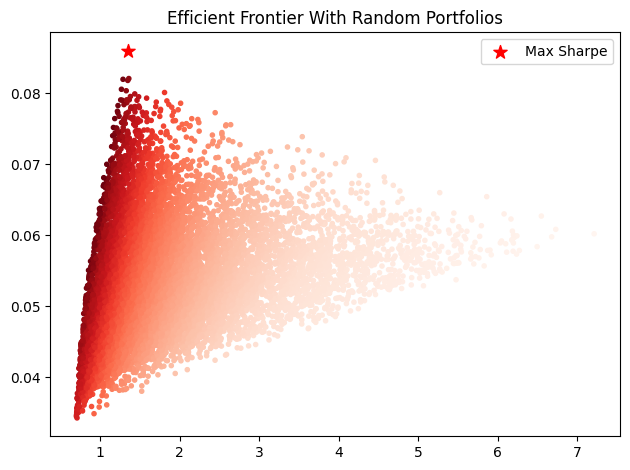

In [77]:
# Markowitz Portfolio

prices = df.pivot_table(index="Date", columns="Region", values="9", aggfunc="mean")

mu = expected_returns.mean_historical_return(prices)
S = risk_models.sample_cov(prices)

ef = EfficientFrontier(mu, S)

weights = ef.max_sharpe()
clean_weights = ef.clean_weights()

print(clean_weights)

ef.portfolio_performance(verbose=True)

ef = EfficientFrontier(mu, S)

fig, ax = plt.subplots()
ef_max_sharpe = ef.deepcopy()

# Find the tangency portfolio
ef_max_sharpe.max_sharpe()
ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="Reds")

# Output
ax.set_title("Efficient Frontier With Random Portfolios")
ax.legend()
plt.tight_layout()
plt.show()